In [1]:
from functions import *

In [2]:
save_path = '/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240515/'

In [3]:
dpi = 300

In [8]:
def generate_posterior(templates, observations, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    observations_flatten = [generate_flatten_distance_map(o) for o in observations]
    
    weight_prior = 1/len(template_weights) 
    total_posterior = 0
    
    for o in observations_flatten:
        curr_obs_list = []
        for t, alpha in zip(templates_flatten, template_weights):
            val = 0
            val += loglikelihood(o, t, measurement_error, num_probes)
            val += logprior(t, num_probes)
            
            # This is the correct one 
            # But the scaling between alpha and weight priors and logliokelihood are so different 
            val += jnp.log(alpha) * weight_renormalization
            val += jnp.log(weight_prior) * weight_renormalization # * 1000 to make sure that they are in the same scale 
            
            # But if we add the alpha directly such that they are in the same scale, 
            # that might help
            # val += alpha
            # val += weight_prior
            
            curr_obs_list.append(val)
        curr_obs_list = jnp.array(curr_obs_list) 
        total_posterior += jscipy.special.logsumexp(curr_obs_list)
    
    return total_posterior

In [2]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain_1 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 5
gaussian_noise_std = 10

observations_1 = generate_observations(template_chain_1, num_observations, gaussian_noise_std)

template_chain_2 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 10
gaussian_noise_std = 10

observations_2 = generate_observations(template_chain_2, num_observations, gaussian_noise_std)

template_chain_3 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

num_observations = 15
gaussian_noise_std = 10

observations_3 = generate_observations(template_chain_3, num_observations, gaussian_noise_std)

templates_list = [template_chain_1, 
                  template_chain_2,
                  template_chain_3]

observation_list = np.concatenate([observations_1, 
                                   observations_2, 
                                   observations_3])

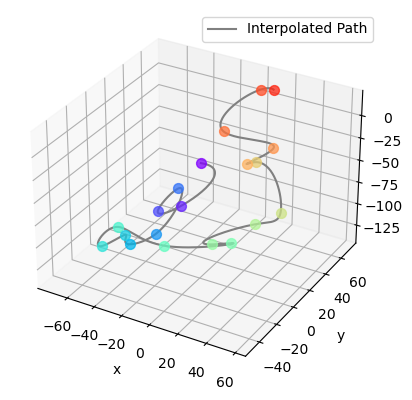

In [5]:
visualize_polymer(template_chain_1, save_path+'template_chain_1.png')


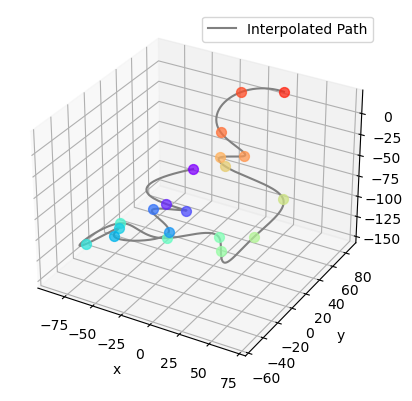

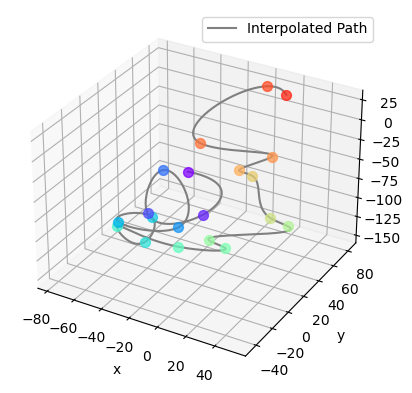

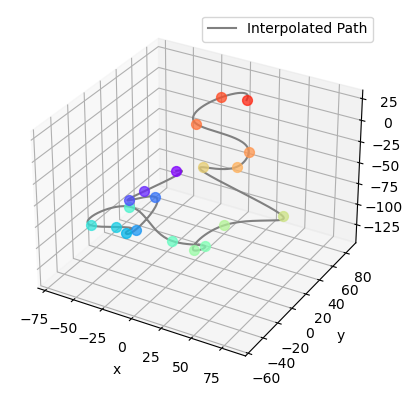

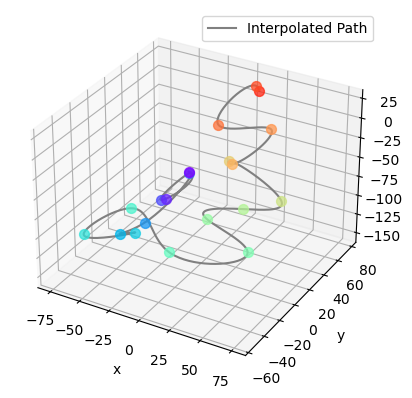

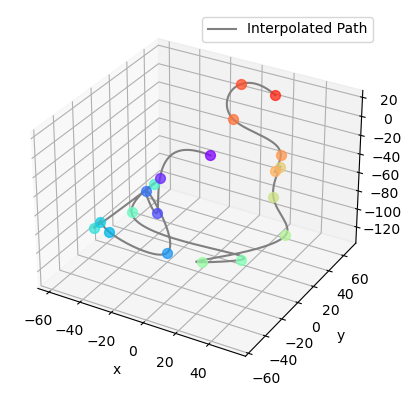

In [6]:
for i, o in enumerate(observations_1):
    visualize_polymer(o, save_path+'template_chain_1_o{}.png'.format(i))

In [10]:
def weight_objective(template_weights):
    """
    """
    templates = templates_list
    observations = observation_list 
    return generate_posterior(templates, observations, template_weights)

def weight_neg_objective(template_weights):
    """
    """
    templates = templates_list
    observations = observation_list 
    return -generate_posterior(templates, observations, template_weights)

In [61]:
# First perform some grid search to see how these weights affect 
# negative log posterior 

measurement_error = 10
num_probes = num_monomers

nlp_array = np.full([20, 20], np.nan)

for n1 in range(20):
    for n2 in range(20):
        nlp = weight_neg_objective([n1, n2, 15])
        nlp_array[n1, n2] = nlp

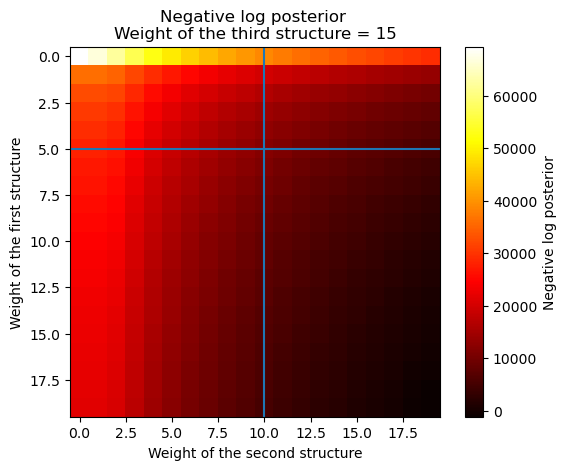

In [62]:
plt.imshow(nlp_array, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()  
cbar.set_label('Negative log posterior')
plt.axhline(5)
plt.axvline(10)
plt.title('Negative log posterior \nWeight of the third structure = 15')
plt.ylabel('Weight of the first structure')
plt.xlabel('Weight of the second structure')

file_path = save_path + 'nlp_grid_search_nobounds.png'
plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

plt.show()

In [63]:
nlp_array = np.full([20, 20], np.nan)

for n1 in range(20):
    for n2 in range(20):
        if n1 + n2 == 15:
            nlp = weight_neg_objective([n1, n2, 15])
            nlp_array[n1, n2] = nlp

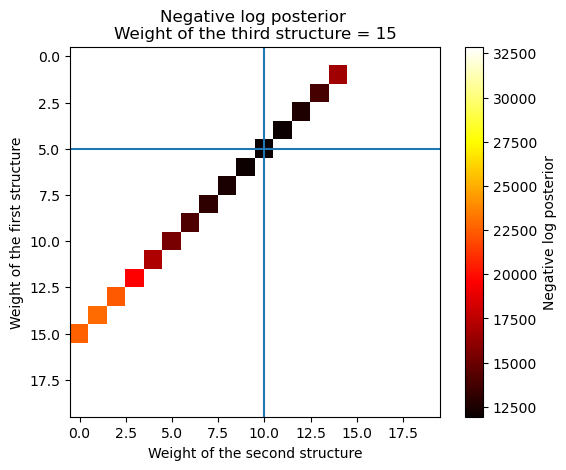

In [64]:
plt.imshow(nlp_array, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()  # Add a colorbar
cbar.set_label('Negative log posterior')
plt.axhline(5)
plt.axvline(10)
plt.title('Negative log posterior \nWeight of the third structure = 15')
plt.ylabel('Weight of the first structure')
plt.xlabel('Weight of the second structure')

file_path = save_path + 'nlp_grid_search_constraints.png'
plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

plt.show()

In [68]:
def weight_neg_objective_no_normalization(template_weights):
    """
    """
    templates = templates_list
    observations = observation_list 
    return -generate_posterior(templates, observations, template_weights, 1)

In [69]:
nlp_array = np.full([20, 20], np.nan)

for n1 in range(20):
    for n2 in range(20):
        if n1 + n2 == 15:
            nlp = weight_neg_objective_no_normalization([n1, n2, 15])
            nlp_array[n1, n2] = nlp

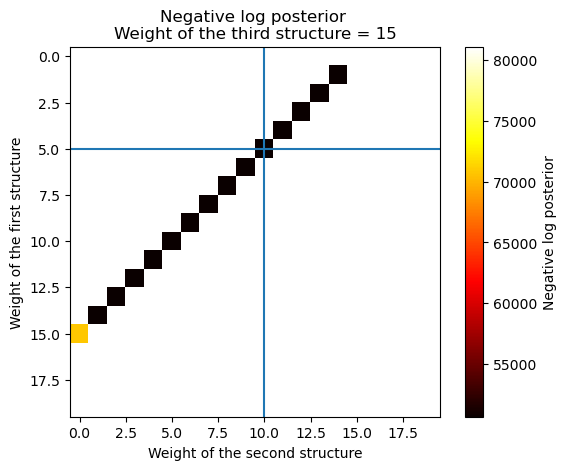

In [70]:
plt.imshow(nlp_array, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()  # Add a colorbar
cbar.set_label('Negative log posterior')
plt.axhline(5)
plt.axvline(10)
plt.title('Negative log posterior \nWeight of the third structure = 15')
plt.ylabel('Weight of the first structure')
plt.xlabel('Weight of the second structure')

file_path = save_path + 'nlp_grid_search_constraints_no_weight_normalization.png'
plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

plt.show()

In [29]:
import jax.random as random

# Create a random key
key = random.PRNGKey(0)

# Generate uniform random numbers
key, subkey = random.split(key)
uniform_array = random.uniform(subkey, shape=(100, 3)) 

initial_weight_guess = uniform_array

In [31]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_simplex

In [33]:
solver = jaxopt.ScipyMinimize(fun=weight_neg_objective, method='L-BFGS-B', tol=1e-6,
                                   options={'disp': False, 'gtol':1e-9})
res_list = []
for i, g in enumerate(initial_weight_guess):
    res = solver.run(jnp.array(g))
    res_list.append(res)

In [49]:
res_param_list = np.array([x.params for x in res_list])

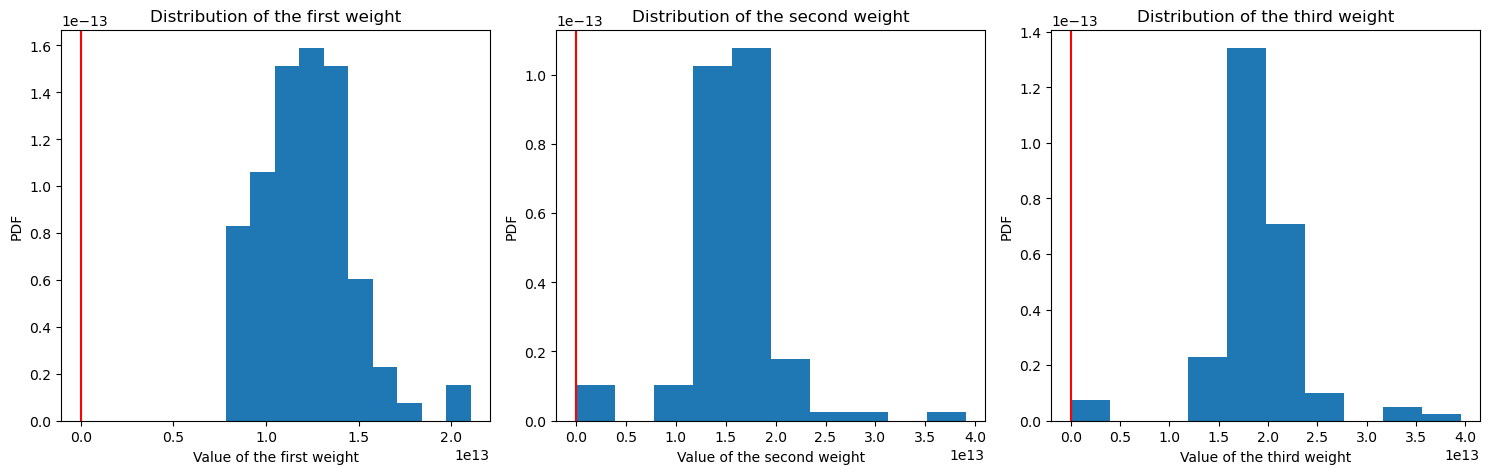

In [65]:
# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
ax1.hist(res_param_list[:, 0], density=True)
ax1.set_title('Distribution of the first weight')
ax1.set_xlabel('Value of the first weight')
ax1.axvline(5, color='r')
ax1.set_ylabel('PDF')

# Second subplot
ax2.hist(res_param_list[:, 1], density=True)
ax2.set_title('Distribution of the second weight')
ax2.set_xlabel('Value of the second weight')
ax2.axvline(10, color='r')
ax2.set_ylabel('PDF')

# Third subplot
ax3.hist(res_param_list[:, 2], density=True)
ax3.set_title('Distribution of the third weight')
ax3.set_xlabel('Value of the third weight')
ax3.axvline(15, color='r')
ax3.set_ylabel('PDF')

# Adjust layout to prevent overlap
plt.tight_layout()



file_path = save_path + 'params_no_constraints.png'
plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

# Show the plot
plt.show()


In [36]:
# Should add the callback function to visualize the convergence path 
pg_list = []
pg = ProjectedGradient(fun=weight_neg_objective, projection=projection_simplex, implicit_diff=True)
for i, g in enumerate(initial_weight_guess):
    pg_sol = pg.run(g, hyperparams_proj=30)
    pg_list.append(pg_sol)

In [41]:
pg_param_list = np.array([x.params for x in pg_list])

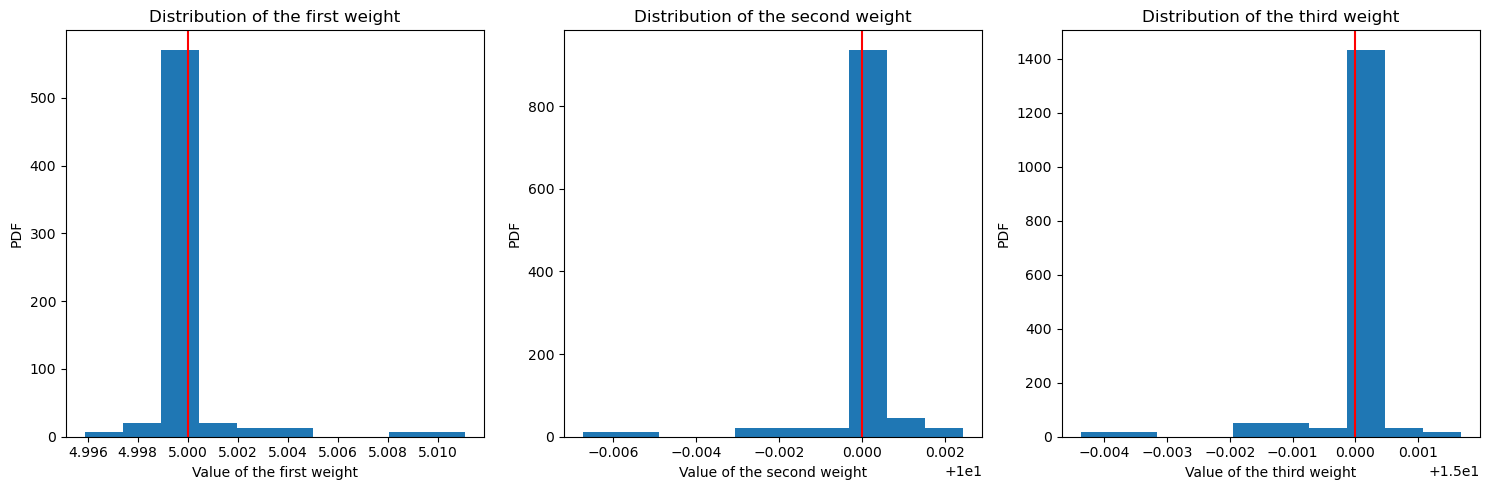

In [66]:
# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
ax1.hist(pg_param_list[:, 0], density=True)
ax1.set_title('Distribution of the first weight')
ax1.set_xlabel('Value of the first weight')
ax1.axvline(5, color='r')
ax1.set_ylabel('PDF')

# Second subplot
ax2.hist(pg_param_list[:, 1], density=True)
ax2.set_title('Distribution of the second weight')
ax2.set_xlabel('Value of the second weight')
ax2.axvline(10, color='r')
ax2.set_ylabel('PDF')

# Third subplot
ax3.hist(pg_param_list[:, 2], density=True)
ax3.set_title('Distribution of the third weight')
ax3.set_xlabel('Value of the third weight')
ax3.axvline(15, color='r')
ax3.set_ylabel('PDF')

# Adjust layout to prevent overlap
plt.tight_layout()


file_path = save_path + 'params_with_constraints.png'
plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

# Show the plot
plt.show()